In [5]:
import matplotlib.pyplot as plt
import numpy as np
import sys; sys.path.append('../')
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchdiffeq as tde
from tqdm import tqdm
from terrarium.utils.nets import MLP
from terrarium.utils.sugar import attrmethod, buildmethod

100%|██████████| 299/299 [00:00<00:00, 46091.25it/s]


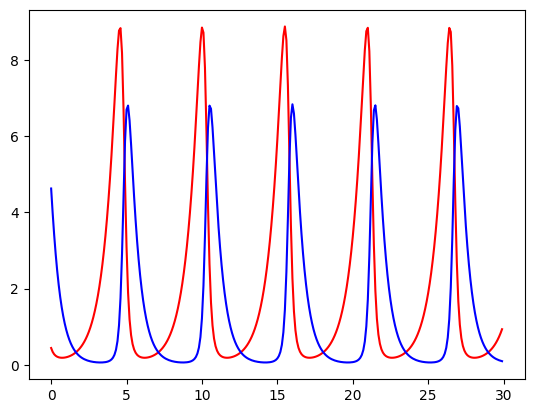

In [6]:
def gLV(x, growth_rates, interactions):
    dx = x*(growth_rates + (interactions@x))

    return dx

def k(x, model=gLV, dt=.1, *args, **kwargs):
    k1 = model(x, *args, **kwargs)
    k2 = model(x + k1*dt/2, *args, **kwargs)
    k3 = model(x + k2*dt/2, *args, **kwargs)
    k4 = model(x + k3*dt, *args, **kwargs)

    return k1, k2, k3, k4

def rk_int(x, model=gLV, dt=.1, n_steps=300, *args, **kwargs):
    (X := np.zeros((n_steps, len(x))))[0] = x

    for i in tqdm(range(1, n_steps)):
        k1, k2, k3, k4 = k(x_ := X[i - 1], model, dt, *args, **kwargs)
        X[i] = x_ + (k1 + 2*k2 + 2*k3 + k4)*dt/6

    return X

dt, n_steps = .1, 300
x = np.array((.44249296, 4.6280594))
growth_rates = np.array((1.3, -1.8))
interactions = np.array(((0., -.9), (.8, 0.)))

X = rk_int(x, gLV, dt, n_steps, growth_rates, interactions)
plt.plot(np.arange(n_steps)*dt, X[:, 0], c='red')
plt.plot(np.arange(n_steps)*dt, X[:, 1], c='blue')
plt.show()

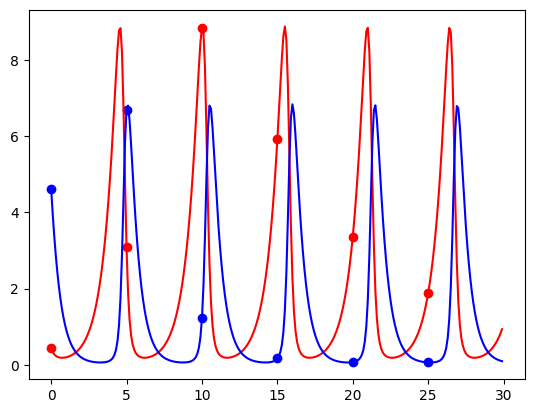

In [7]:
data = X[idx := np.arange(0, len(X), 50)]
plt.plot(np.arange(n_steps)*dt, X[:, 0], c='red')
plt.plot(np.arange(n_steps)*dt, X[:, 1], c='blue')
plt.scatter(idx*dt, data[:, 0], c='red')
plt.scatter(idx*dt, data[:, 1], c='blue')
plt.show()

In [ ]:
class UDE(nn.Module):
    @attrmethod
    def __init__(self, bias=True, norm_layer='batch', act_layer='relu', optim='adam', *args, **kwargs):
        super().__init__(*args, **kwargs)

    def _build(self, X, learning_rate=1e-1):
        channels = (in_channels := X.shape[1], 2*in_channels, in_channels)
        self.model_ = MLP(*channels, bias=self.bias, norm_layer=self.norm_layer, act_layer=self.act_layer)
        self.optim_ = OPTIMS[self.optim](self.parameters(), learning_rate)

        return self

    @buildmethod
    def fit(self, x, n_steps=300, n_epochs=1000, learning_rate=1e-1, verbosity=1):
        for i in tqdm(range(n_epochs)) if verbosity > 0 else range(n_epochs):
            pass